# 📊 Drug Safety Hypothesis Testing Analysis
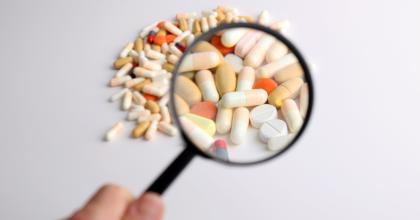
---

## 🏢 Business Understanding

### Background
**GlobalXYZ Pharmaceuticals** has completed a randomized controlled drug trial and provided the dataset to our non-profit organization, which specializes in drug safety research. Our mission is to ensure transparency and reproducibility in pharmaceutical research by conducting independent safety analyses.

### Problem Statement
The primary concern is to determine whether the new drug causes adverse reactions at a significantly different rate compared to placebo. This analysis will inform regulatory decisions and patient safety guidelines.

### Business Questions
1. **Do the proportions of adverse effects differ significantly between Drug and Placebo groups?**
2. **Is the number of adverse effects independent of treatment assignment?**
3. **Are there demographic differences (specifically age) between treatment groups that might confound results?**

### Success Criteria
- Statistical significance assessed at **α = 0.05** level
- Clear determination of drug safety profile relative to placebo
- Identification of any demographic imbalances that could affect interpretation

---

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import warnings
import json
import os
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind, shapiro
import warnings
warnings.simplefilter('ignore')
# Set up visualization parameters
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

## 📁 Data Understanding

### Dataset Overview
- **Source**: Vanderbilt University Department of Biostatistics (Hbiostat)
- **Study Design**: Randomized controlled trial with 2:1 drug-to-placebo ratio
- **Sample Size**: 16,103 participants
- **Follow-up Period**: 20 weeks
- **Adverse Effects Tracked**: Headache, abdominal pain, dyspepsia, upper respiratory infection, COAD

### Data Dictionary

| Variable | Type | Description | Values/Range |
|----------|------|-------------|--------------|
| `age` | Numeric | Participant age in years | 39-84 |
| `sex` | Categorical | Gender of participant | male, female |
| `trx` | Categorical | Treatment assignment | Drug, Placebo |
| `week` | Numeric | Week of observation | 0-20 |
| `wbc` | Numeric | White blood cell count | 1.8-26.5 |
| `rbc` | Numeric | Red blood cell count | 2.1-7.6 |
| `adverse_effects` | Binary | Presence of adverse effects | Yes, No |
| `num_effects` | Discrete | Count of adverse effects | 0-3 |


## 🔧 Data Preparation

### Loading and Initial Inspection
In this section, we:
1. Load the clinical trial dataset
2. Export to JSON format for downstream processes
3. Display basic structure and dimensions
4. Verify data types and formats

---

In [12]:
# Load the dataset
print("Loading drug safety dataset...")
df = pd.read_csv('data/drug_safety.csv')

# Save the input data to JSON format for downstream processes
print("Converting to JSON format for downstream processes...")
df.to_json('data/input_data_drug_safety.json', orient='records', indent=2)

print("✓ Input data saved to JSON format")
print(f"Dataset shape: {df.shape}")
print(f"JSON file saved to: data/input_data_drug_safety.json")

# Display first few rows and basic information
print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)

print(f"Dataset dimensions: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns)}")

print("\nFirst 10 rows:")
df.head(10)

Loading drug safety dataset...
Converting to JSON format for downstream processes...
✓ Input data saved to JSON format
Dataset shape: (16103, 8)
JSON file saved to: data/input_data_drug_safety.json

DATASET OVERVIEW
Dataset dimensions: 16103 rows × 8 columns

Columns: ['age', 'sex', 'trx', 'week', 'wbc', 'rbc', 'adverse_effects', 'num_effects']

First 10 rows:


,age,sex,trx,week,wbc,rbc,adverse_effects,num_effects
0,62,male,Drug,0,7.3,5.1,No,0
1,62,male,Drug,1,NaN,NaN,No,0
2,62,male,Drug,12,5.6,5.0,No,0
3,62,male,Drug,16,NaN,NaN,No,0
4,62,male,Drug,2,6.6,5.1,No,0
5,62,male,Drug,20,NaN,NaN,Yes,1
6,62,male,Drug,4,6.9,5.2,Yes,1
7,62,male,Drug,8,7.1,5.0,Yes,1
8,69,male,Drug,0,8.8,5.1,No,0
9,69,male,Drug,1,NaN,NaN,No,0


In [3]:
# Data validation and structure analysis
print("DATA QUALITY ASSESSMENT")
print("="*60)

# Check data types
print("\nData types:")
print(df.dtypes)

# Check for missing values
print(f"\nMissing values:")
missing_counts = df.isnull().sum()
missing_percentages = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage': missing_percentages.round(2)
})
display(missing_df)

# Check unique values for categorical variables
print(f"\nUnique values in categorical columns:")
for col in ['sex', 'trx', 'adverse_effects']:
    if col in df.columns:
        print(f"{col}: {df[col].unique()}")
        print(f"   Value counts: {dict(df[col].value_counts())}")

# Check treatment distribution (should be 2:1 Drug:Placebo)
print(f"\nTreatment distribution:")
trx_counts = df['trx'].value_counts()
print(trx_counts)
print(f"Drug:Placebo ratio = {trx_counts['Drug']/trx_counts['Placebo']:.2f}:1")

# Summary statistics
print(f"\nSUMMARY STATISTICS")
print("="*60)
df.describe()

DATA QUALITY ASSESSMENT

Data types:
age                  int64
sex                 object
trx                 object
week                 int64
wbc                float64
rbc                float64
adverse_effects     object
num_effects          int64
dtype: object

Missing values:


,Missing Count,Missing Percentage
age,0,0.00
sex,0,0.00
trx,0,0.00
week,0,0.00
wbc,6975,43.31
rbc,6976,43.32
adverse_effects,0,0.00
num_effects,0,0.00



Unique values in categorical columns:
sex: ['male' 'female']
   Value counts: {'male': np.int64(12328), 'female': np.int64(3775)}
trx: ['Drug' 'Placebo']
   Value counts: {'Drug': np.int64(10727), 'Placebo': np.int64(5376)}
adverse_effects: ['No' 'Yes']
   Value counts: {'No': np.int64(14567), 'Yes': np.int64(1536)}

Treatment distribution:
trx
Drug       10727
Placebo     5376
Name: count, dtype: int64
Drug:Placebo ratio = 2.00:1

SUMMARY STATISTICS


,age,week,wbc,rbc,num_effects
count,16103.000000,16103.00000,9128.000000,9127.000000,16103.000000
mean,64.117556,7.74098,7.340557,4.672784,0.101596
std,8.783207,6.94350,1.996652,0.458520,0.323181
min,39.000000,0.00000,1.800000,2.100000,0.000000
25%,58.000000,1.00000,6.000000,4.400000,0.000000
50%,65.000000,4.00000,7.100000,4.700000,0.000000
75%,71.000000,12.00000,8.400000,5.000000,0.000000
max,84.000000,20.00000,26.500000,7.600000,3.000000


In [4]:
# Summary statistics by treatment group
print("\nSUMMARY STATISTICS BY TREATMENT GROUP")
print("="*60)

# Create summary by treatment group
summary_by_treatment = df.groupby('trx').agg({
    'age': ['mean', 'std', 'min', 'max'],
    'sex': lambda x: (x == 'male').sum(),  # Count of males
    'adverse_effects': lambda x: (x == 'Yes').sum(),  # Count with adverse effects
    'num_effects': ['mean', 'std', 'min', 'max'],
    'wbc': ['mean', 'std'],
    'rbc': ['mean', 'std']
}).round(2)

print("Treatment Group Summary:")
print(summary_by_treatment)

# Calculate demographic breakdown
print(f"\nDEMOGRAPHIC BREAKDOWN BY TREATMENT GROUP")
print("="*50)

demo_breakdown = df.groupby(['trx', 'sex']).size().unstack(fill_value=0)
demo_breakdown_pct = df.groupby(['trx', 'sex']).size().unstack(fill_value=0)
demo_breakdown_pct = (demo_breakdown_pct.div(demo_breakdown_pct.sum(axis=1), axis=0) * 100).round(1)

print("Counts:")
print(demo_breakdown)
print(f"\nPercentages:")
print(demo_breakdown_pct)

# Adverse effects breakdown
print(f"\nADVERSE EFFECTS BREAKDOWN BY TREATMENT GROUP")
print("="*50)

adverse_breakdown = pd.crosstab(df['trx'], df['adverse_effects'], margins=True)
adverse_breakdown_pct = pd.crosstab(df['trx'], df['adverse_effects'], normalize='index') * 100
adverse_breakdown_pct = adverse_breakdown_pct.round(2)

print("Counts:")
print(adverse_breakdown)
print(f"\nPercentages:")
print(adverse_breakdown_pct)


SUMMARY STATISTICS BY TREATMENT GROUP
Treatment Group Summary:
           age                    sex adverse_effects num_effects            \
          mean   std min max <lambda>        <lambda>        mean   std min   
trx                                                                           
Drug     64.19  8.73  39  82     8135            1024         0.1  0.33   0   
Placebo  63.97  8.89  39  84     4193             512         0.1  0.32   0   

              wbc         rbc        
        max  mean   std  mean   std  
trx                                  
Drug      3  7.33  2.01  4.68  0.45  
Placebo   3  7.36  1.97  4.66  0.47  

DEMOGRAPHIC BREAKDOWN BY TREATMENT GROUP
Counts:
sex      female  male
trx                  
Drug       2592  8135
Placebo    1183  4193

Percentages:
sex      female  male
trx                  
Drug       24.2  75.8
Placebo    22.0  78.0

ADVERSE EFFECTS BREAKDOWN BY TREATMENT GROUP
Counts:
adverse_effects     No   Yes    All
trx                 

CREATING DISTRIBUTION VISUALIZATIONS


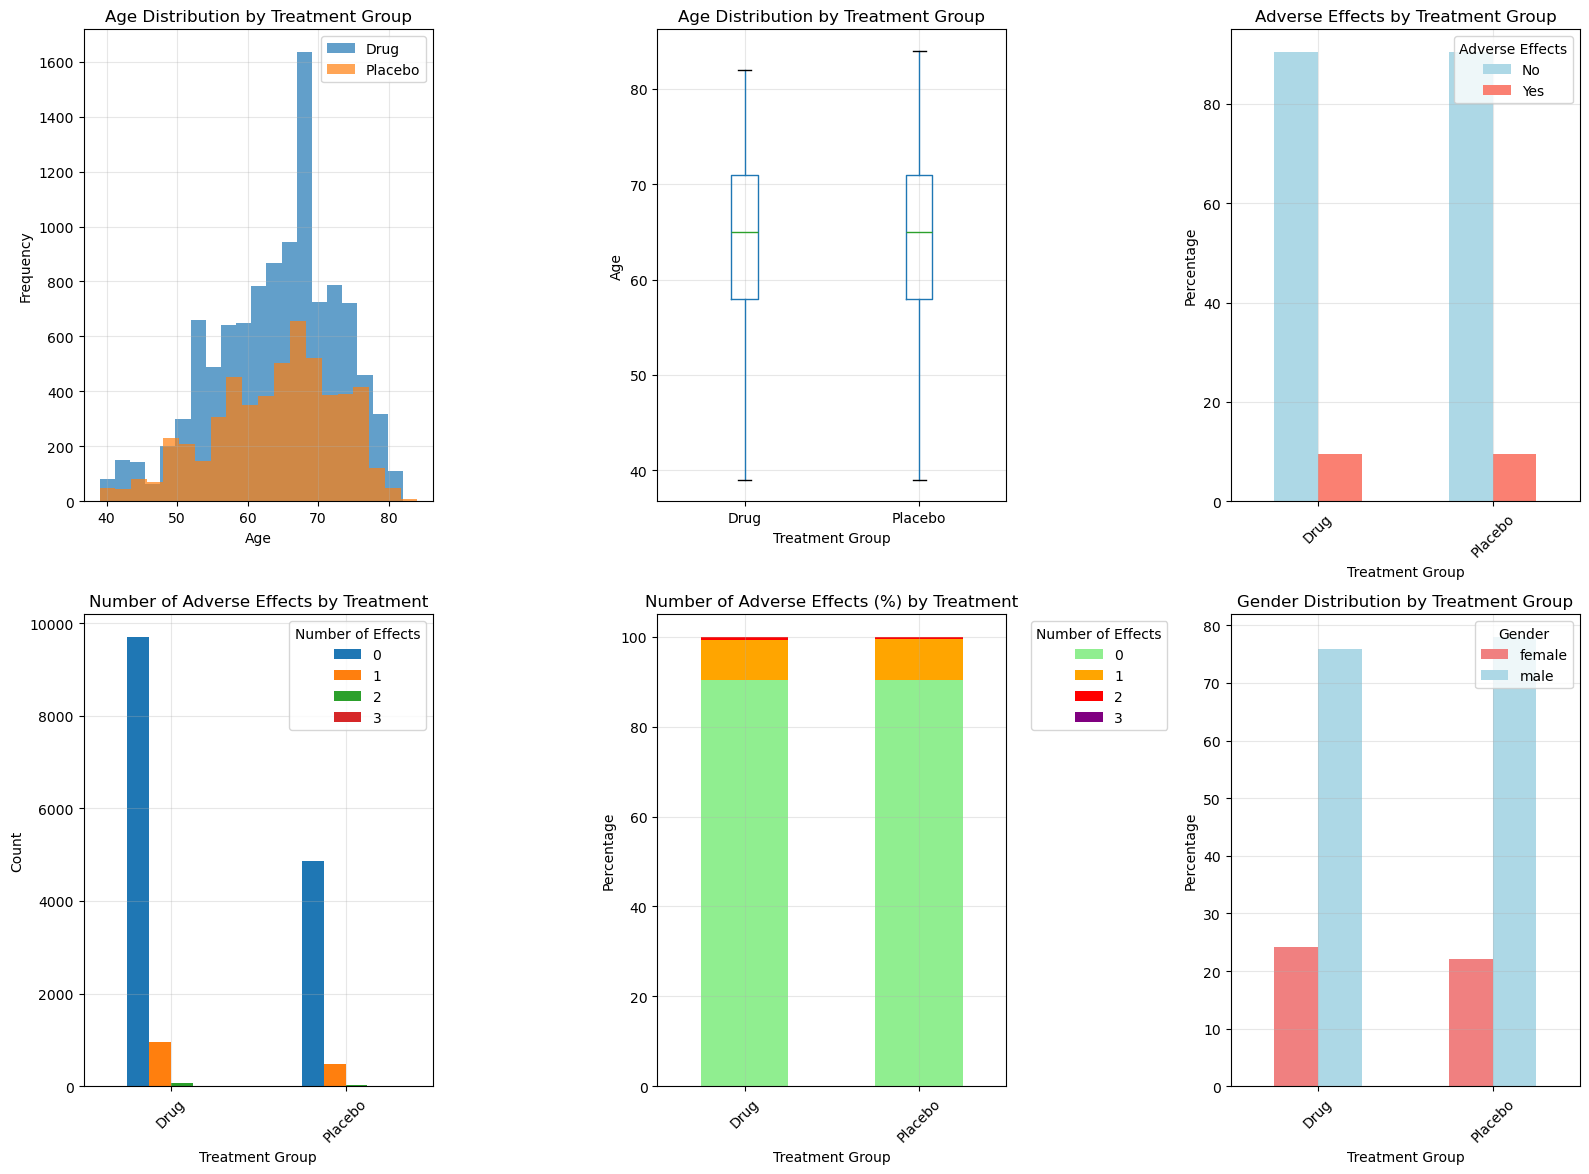

In [5]:
# Create distribution visualizations
print("CREATING DISTRIBUTION VISUALIZATIONS")
print("="*50)

# Set up the plotting style
plt.style.use('default')
fig = plt.figure(figsize=(16, 12))

# 1. Age distribution by treatment group
plt.subplot(2, 3, 1)
for trx in df['trx'].unique():
    subset = df[df['trx'] == trx]['age']
    plt.hist(subset, alpha=0.7, label=trx, bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution by Treatment Group')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Box plot of age by treatment
plt.subplot(2, 3, 2)
df.boxplot(column='age', by='trx', ax=plt.gca())
plt.title('Age Distribution by Treatment Group')
plt.suptitle('')  # Remove default title
plt.xlabel('Treatment Group')
plt.ylabel('Age')
plt.grid(True, alpha=0.3)

# 3. Adverse effects by treatment (bar chart)
plt.subplot(2, 3, 3)
adverse_counts = pd.crosstab(df['trx'], df['adverse_effects'])
adverse_pct = pd.crosstab(df['trx'], df['adverse_effects'], normalize='index') * 100
adverse_pct.plot(kind='bar', ax=plt.gca(), color=['lightblue', 'salmon'])
plt.title('Adverse Effects by Treatment Group')
plt.xlabel('Treatment Group')
plt.ylabel('Percentage')
plt.legend(title='Adverse Effects')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 4. Number of effects distribution
plt.subplot(2, 3, 4)
num_effects_counts = pd.crosstab(df['trx'], df['num_effects'])
num_effects_counts.plot(kind='bar', ax=plt.gca(), stacked=False)
plt.title('Number of Adverse Effects by Treatment')
plt.xlabel('Treatment Group')
plt.ylabel('Count')
plt.legend(title='Number of Effects')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 5. Stacked bar chart for number of effects
plt.subplot(2, 3, 5)
num_effects_pct = pd.crosstab(df['trx'], df['num_effects'], normalize='index') * 100
num_effects_pct.plot(kind='bar', ax=plt.gca(), stacked=True, 
                     color=['lightgreen', 'orange', 'red', 'purple'])
plt.title('Number of Adverse Effects (%) by Treatment')
plt.xlabel('Treatment Group')
plt.ylabel('Percentage')
plt.legend(title='Number of Effects', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 6. Gender distribution
plt.subplot(2, 3, 6)
gender_counts = pd.crosstab(df['trx'], df['sex'], normalize='index') * 100
gender_counts.plot(kind='bar', ax=plt.gca(), color=['lightcoral', 'lightblue'])
plt.title('Gender Distribution by Treatment Group')
plt.xlabel('Treatment Group')
plt.ylabel('Percentage')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 🧪 Hypothesis Testing

### Overview
We conduct three statistical tests to answer our business questions. Each test follows the formal hypothesis testing framework:
1. State null and alternative hypotheses
2. Choose appropriate test based on data characteristics
3. Check assumptions
4. Calculate test statistic and p-value
5. Make decision based on significance level (α = 0.05)
6. Interpret results in context

---

In [6]:
# Statistical Test 1: Two-Sample Proportion Test
print("STATISTICAL TEST 1: TWO-SAMPLE PROPORTION TEST")
print("="*60)
print("Question: Do the proportions of adverse effects differ significantly between Drug and Placebo groups?")
print()

# Calculate proportions for each group
drug_group = df[df['trx'] == 'Drug']
placebo_group = df[df['trx'] == 'Placebo']

# Count adverse effects
drug_adverse = (drug_group['adverse_effects'] == 'Yes').sum()
drug_total = len(drug_group)
drug_prop = drug_adverse / drug_total

placebo_adverse = (placebo_group['adverse_effects'] == 'Yes').sum()
placebo_total = len(placebo_group)
placebo_prop = placebo_adverse / placebo_total

print(f"Drug Group:")
print(f"  Total participants: {drug_total}")
print(f"  Adverse effects: {drug_adverse}")
print(f"  Proportion with adverse effects: {drug_prop:.4f} ({drug_prop*100:.2f}%)")

print(f"\nPlacebo Group:")
print(f"  Total participants: {placebo_total}")
print(f"  Adverse effects: {placebo_adverse}")
print(f"  Proportion with adverse effects: {placebo_prop:.4f} ({placebo_prop*100:.2f}%)")

print(f"\nDifference in proportions (Drug - Placebo): {drug_prop - placebo_prop:.4f}")

# Perform two-sample proportion test
counts = np.array([drug_adverse, placebo_adverse])
nobs = np.array([drug_total, placebo_total])

# Use statsmodels proportions_ztest
z_stat, two_sample_p_value = proportions_ztest(counts, nobs)

print(f"\nTwo-Sample Proportion Test Results:")
print(f"  Z-statistic: {z_stat:.4f}")
print(f"  P-value: {two_sample_p_value:.6f}")

# Effect size (Cohen's h)
h_effect_size = 2 * (np.arcsin(np.sqrt(drug_prop)) - np.arcsin(np.sqrt(placebo_prop)))
print(f"  Effect size (Cohen's h): {h_effect_size:.4f}")

# Confidence interval for difference in proportions
from statsmodels.stats.proportion import confint_proportions_2indep

# Calculate 95% CI for difference
ci_low, ci_high = confint_proportions_2indep(drug_adverse, drug_total, 
                                           placebo_adverse, placebo_total,
                                           method='wald')
print(f"  95% Confidence Interval for difference: [{ci_low:.4f}, {ci_high:.4f}]")

# Interpretation
alpha = 0.05
print(f"\nInterpretation (α = {alpha}):")
if two_sample_p_value < alpha:
    print(f"  ✓ Reject the null hypothesis (p = {two_sample_p_value:.6f} < {alpha})")
    print(f"  There IS a statistically significant difference in adverse effect proportions between groups.")
else:
    print(f"  ✗ Fail to reject the null hypothesis (p = {two_sample_p_value:.6f} ≥ {alpha})")
    print(f"  There is NO statistically significant difference in adverse effect proportions between groups.")

print(f"\nSaved variable: two_sample_p_value = {two_sample_p_value}")

STATISTICAL TEST 1: TWO-SAMPLE PROPORTION TEST
Question: Do the proportions of adverse effects differ significantly between Drug and Placebo groups?

Drug Group:
  Total participants: 10727
  Adverse effects: 1024
  Proportion with adverse effects: 0.0955 (9.55%)

Placebo Group:
  Total participants: 5376
  Adverse effects: 512
  Proportion with adverse effects: 0.0952 (9.52%)

Difference in proportions (Drug - Placebo): 0.0002

Two-Sample Proportion Test Results:
  Z-statistic: 0.0452
  P-value: 0.963933
  Effect size (Cohen's h): 0.0008
  95% Confidence Interval for difference: [-0.0094, 0.0098]

Interpretation (α = 0.05):
  ✗ Fail to reject the null hypothesis (p = 0.963933 ≥ 0.05)
  There is NO statistically significant difference in adverse effect proportions between groups.

Saved variable: two_sample_p_value = 0.9639333330262475


In [7]:
# Statistical Test 2: Chi-Square Test of Independence
print("\nSTATISTICAL TEST 2: CHI-SQUARE TEST OF INDEPENDENCE")
print("="*60)
print("Question: Is the number of adverse effects independent of treatment groups?")
print()

# Create contingency table
contingency_table = pd.crosstab(df['num_effects'], df['trx'])
print("Contingency Table (num_effects vs treatment):")
print(contingency_table)

# Calculate percentages for better interpretation
contingency_pct = pd.crosstab(df['num_effects'], df['trx'], normalize='columns') * 100
print(f"\nPercentages by Treatment Group:")
print(contingency_pct.round(2))

# Perform chi-square test
chi2_stat, num_effects_p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-Square Test Results:")
print(f"  Chi-square statistic: {chi2_stat:.4f}")
print(f"  P-value: {num_effects_p_value:.6f}")
print(f"  Degrees of freedom: {dof}")

# Calculate effect size (Cramér's V)
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2_stat / (n * (min(contingency_table.shape) - 1)))
print(f"  Effect size (Cramér's V): {cramers_v:.4f}")

# Show expected frequencies
expected_df = pd.DataFrame(expected, 
                          index=contingency_table.index, 
                          columns=contingency_table.columns)
print(f"\nExpected frequencies:")
print(expected_df.round(2))

# Check assumptions (expected frequencies >= 5)
min_expected = expected.min()
print(f"\nAssumption check:")
print(f"  Minimum expected frequency: {min_expected:.2f}")
if min_expected >= 5:
    print("  ✓ All expected frequencies ≥ 5 (assumption satisfied)")
else:
    print("  ⚠ Some expected frequencies < 5 (assumption violated)")

# Interpretation
alpha = 0.05
print(f"\nInterpretation (α = {alpha}):")
if num_effects_p_value < alpha:
    print(f"  ✓ Reject the null hypothesis (p = {num_effects_p_value:.6f} < {alpha})")
    print(f"  The number of adverse effects IS associated with treatment group.")
else:
    print(f"  ✗ Fail to reject the null hypothesis (p = {num_effects_p_value:.6f} ≥ {alpha})")
    print(f"  The number of adverse effects is NOT associated with treatment group.")

print(f"\nSaved variable: num_effects_p_value = {num_effects_p_value}")


STATISTICAL TEST 2: CHI-SQUARE TEST OF INDEPENDENCE
Question: Is the number of adverse effects independent of treatment groups?

Contingency Table (num_effects vs treatment):
trx          Drug  Placebo
num_effects               
0            9703     4864
1             956      486
2              63       25
3               5        1

Percentages by Treatment Group:
trx           Drug  Placebo
num_effects                
0            90.45    90.48
1             8.91     9.04
2             0.59     0.47
3             0.05     0.02

Chi-Square Test Results:
  Chi-square statistic: 1.7996
  P-value: 0.615012
  Degrees of freedom: 3
  Effect size (Cramér's V): 0.0106

Expected frequencies:
trx             Drug  Placebo
num_effects                  
0            9703.79  4863.21
1             960.59   481.41
2              58.62    29.38
3               4.00     2.00

Assumption check:
  Minimum expected frequency: 2.00
  ⚠ Some expected frequencies < 5 (assumption violated)

Interpretat

In [8]:
# Statistical Test 3: Age Group Comparison Test
print("\nSTATISTICAL TEST 3: AGE GROUP COMPARISON TEST")
print("="*60)
print("Question: Is there a significant difference between ages of Drug and Placebo groups?")
print()

# Extract age data for each group
drug_ages = df[df['trx'] == 'Drug']['age'].dropna()
placebo_ages = df[df['trx'] == 'Placebo']['age'].dropna()

print(f"Age data summary:")
print(f"  Drug group: n = {len(drug_ages)}, mean = {drug_ages.mean():.2f}, std = {drug_ages.std():.2f}")
print(f"  Placebo group: n = {len(placebo_ages)}, mean = {placebo_ages.mean():.2f}, std = {placebo_ages.std():.2f}")
print(f"  Difference in means: {drug_ages.mean() - placebo_ages.mean():.2f}")

# Test for normality using Shapiro-Wilk test (sample if needed due to size limitations)
print(f"\nNormality tests (Shapiro-Wilk, n=5000 sample if larger):")

# Sample for normality test if datasets are large
drug_sample = drug_ages.sample(min(5000, len(drug_ages)), random_state=42)
placebo_sample = placebo_ages.sample(min(5000, len(placebo_ages)), random_state=42)

drug_shapiro_stat, drug_shapiro_p = shapiro(drug_sample)
placebo_shapiro_stat, placebo_shapiro_p = shapiro(placebo_sample)

print(f"  Drug group: W = {drug_shapiro_stat:.4f}, p = {drug_shapiro_p:.6f}")
print(f"  Placebo group: W = {placebo_shapiro_stat:.4f}, p = {placebo_shapiro_p:.6f}")

# Check if data is normal (p > 0.05 suggests normality)
drug_normal = drug_shapiro_p > 0.05
placebo_normal = placebo_shapiro_p > 0.05
both_normal = drug_normal and placebo_normal

print(f"  Drug group normal: {drug_normal}")
print(f"  Placebo group normal: {placebo_normal}")
print(f"  Both groups normal: {both_normal}")

# Choose appropriate test based on normality
if both_normal:
    print(f"\n→ Using Independent t-test (data appears normal)")
    # Levene's test for equal variances
    from scipy.stats import levene
    levene_stat, levene_p = levene(drug_ages, placebo_ages)
    print(f"  Levene's test for equal variances: F = {levene_stat:.4f}, p = {levene_p:.6f}")
    equal_var = levene_p > 0.05
    print(f"  Equal variances assumption: {equal_var}")
    
    # Perform t-test
    t_stat, age_group_effects_p_value = ttest_ind(drug_ages, placebo_ages, equal_var=equal_var)
    test_used = f"Independent t-test (equal_var={equal_var})"
    test_statistic = t_stat
    
    # Calculate Cohen's d (effect size)
    pooled_std = np.sqrt(((len(drug_ages)-1)*drug_ages.var() + (len(placebo_ages)-1)*placebo_ages.var()) / (len(drug_ages)+len(placebo_ages)-2))
    cohens_d = (drug_ages.mean() - placebo_ages.mean()) / pooled_std
    effect_size_name = "Cohen's d"
    effect_size_value = cohens_d
    
else:
    print(f"\n→ Using Mann-Whitney U test (data not normal)")
    # Perform Mann-Whitney U test
    u_stat, age_group_effects_p_value = mannwhitneyu(drug_ages, placebo_ages, alternative='two-sided')
    test_used = "Mann-Whitney U test"
    test_statistic = u_stat
    
    # Calculate rank-biserial correlation (effect size for Mann-Whitney U)
    n1, n2 = len(drug_ages), len(placebo_ages)
    r_rb = 1 - (2*u_stat)/(n1*n2)
    effect_size_name = "Rank-biserial correlation"
    effect_size_value = r_rb

print(f"\n{test_used} Results:")
print(f"  Test statistic: {test_statistic:.4f}")
print(f"  P-value: {age_group_effects_p_value:.6f}")
print(f"  Effect size ({effect_size_name}): {effect_size_value:.4f}")

# Confidence interval for mean difference (if t-test was used)
if both_normal:
    from scipy.stats import t
    # Calculate 95% CI for difference in means
    diff_mean = drug_ages.mean() - placebo_ages.mean()
    se_diff = pooled_std * np.sqrt(1/len(drug_ages) + 1/len(placebo_ages))
    df_t = len(drug_ages) + len(placebo_ages) - 2
    t_crit = t.ppf(0.975, df_t)
    ci_low = diff_mean - t_crit * se_diff
    ci_high = diff_mean + t_crit * se_diff
    print(f"  95% CI for difference in means: [{ci_low:.3f}, {ci_high:.3f}]")

# Interpretation
alpha = 0.05
print(f"\nInterpretation (α = {alpha}):")
if age_group_effects_p_value < alpha:
    print(f"  ✓ Reject the null hypothesis (p = {age_group_effects_p_value:.6f} < {alpha})")
    print(f"  There IS a statistically significant difference in ages between treatment groups.")
else:
    print(f"  ✗ Fail to reject the null hypothesis (p = {age_group_effects_p_value:.6f} ≥ {alpha})")
    print(f"  There is NO statistically significant difference in ages between treatment groups.")

print(f"\nSaved variable: age_group_effects_p_value = {age_group_effects_p_value}")


STATISTICAL TEST 3: AGE GROUP COMPARISON TEST
Question: Is there a significant difference between ages of Drug and Placebo groups?

Age data summary:
  Drug group: n = 10727, mean = 64.19, std = 8.73
  Placebo group: n = 5376, mean = 63.97, std = 8.89
  Difference in means: 0.22

Normality tests (Shapiro-Wilk, n=5000 sample if larger):
  Drug group: W = 0.9770, p = 0.000000
  Placebo group: W = 0.9754, p = 0.000000
  Drug group normal: False
  Placebo group normal: False
  Both groups normal: False

→ Using Mann-Whitney U test (data not normal)

Mann-Whitney U test Results:
  Test statistic: 29149339.5000
  P-value: 0.256963
  Effect size (Rank-biserial correlation): -0.0109

Interpretation (α = 0.05):
  ✗ Fail to reject the null hypothesis (p = 0.256963 ≥ 0.05)
  There is NO statistically significant difference in ages between treatment groups.

Saved variable: age_group_effects_p_value = 0.25696267004066287


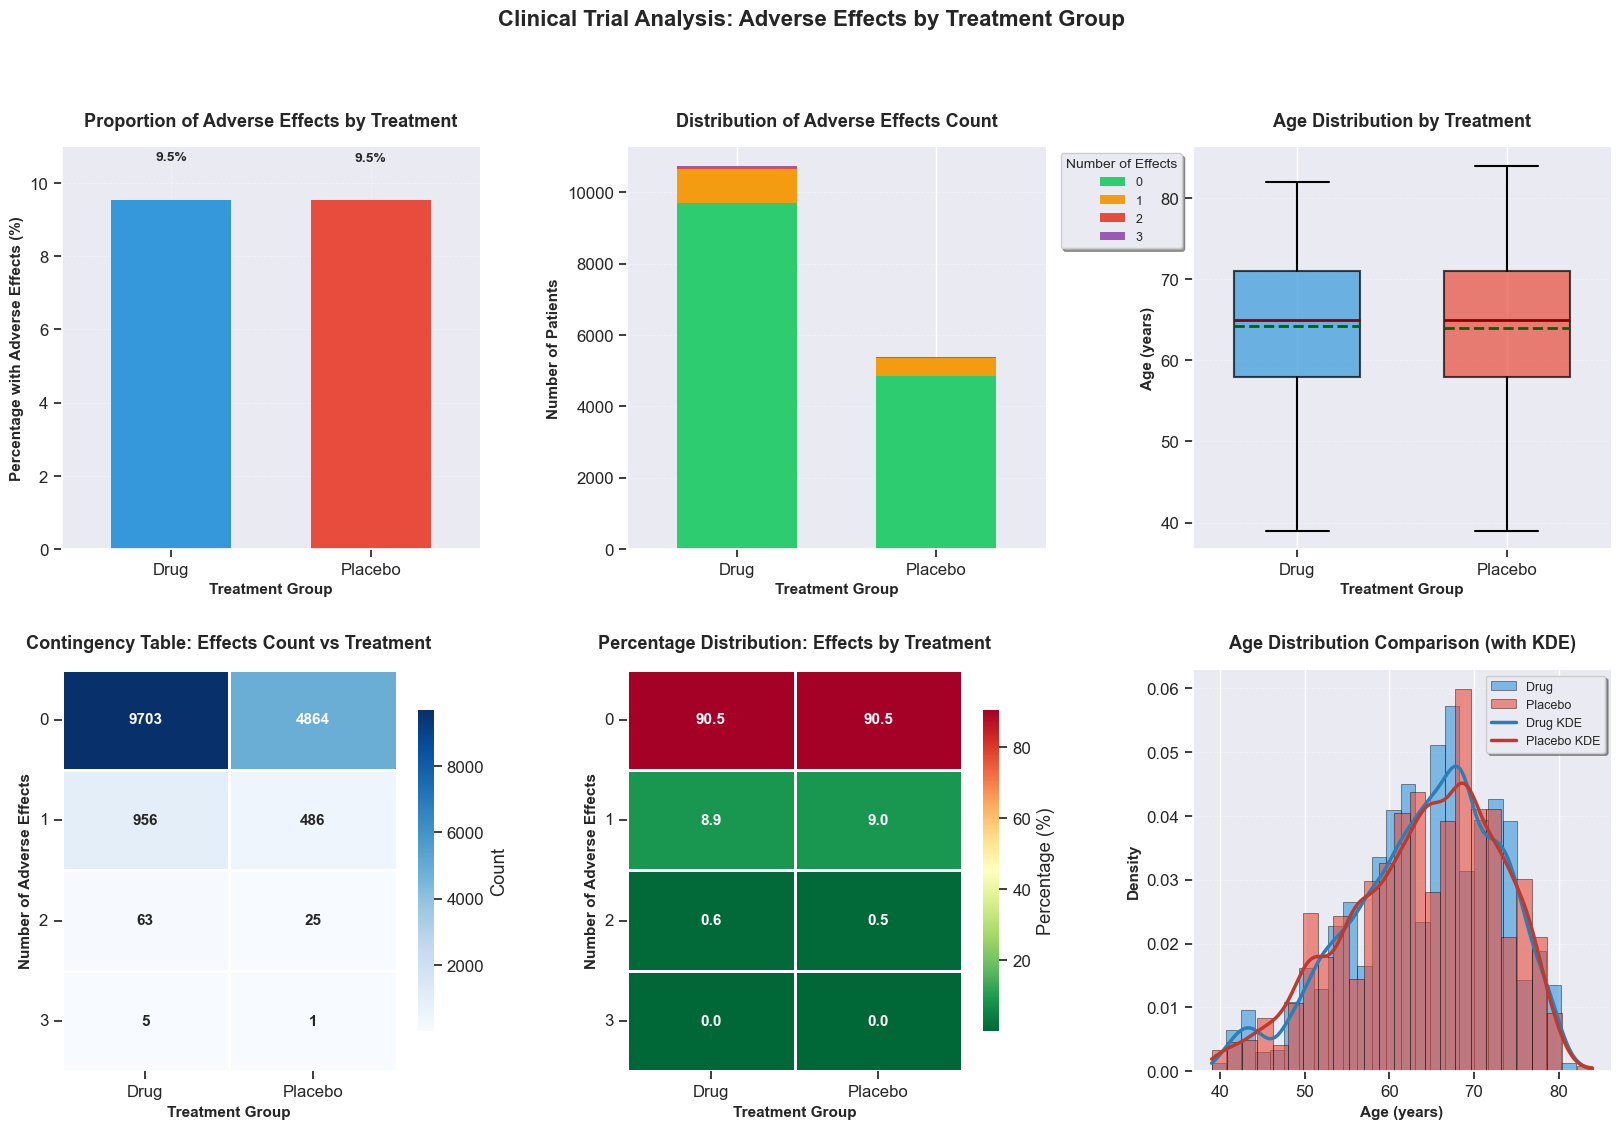

✓ Professional visualizations created and saved


In [9]:
# Set professional style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.1)

# Create figure with better spacing
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.35)

# Define professional color palette
colors_treatment = ['#3498db', '#e74c3c']  # Blue for Drug, Red for Placebo
colors_stacked = ['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']  # Green, Orange, Red, Purple

# ==========================================
# 1. Bar chart: Proportion of adverse effects
# ==========================================
ax1 = fig.add_subplot(gs[0, 0])
adverse_props = pd.crosstab(df['trx'], df['adverse_effects'], normalize='index') * 100
bars = adverse_props['Yes'].plot(kind='bar', color=colors_treatment, rot=0, ax=ax1, width=0.6)
ax1.set_title('Proportion of Adverse Effects by Treatment', fontsize=13, fontweight='bold', pad=15)
ax1.set_xlabel('Treatment Group', fontsize=11, fontweight='bold')
ax1.set_ylabel('Percentage with Adverse Effects (%)', fontsize=11, fontweight='bold')
ax1.set_ylim(0, max(adverse_props['Yes'].values) * 1.15)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add value labels
for i, v in enumerate(adverse_props['Yes'].values):
    ax1.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# ==========================================
# 2. Stacked bar chart: Number of effects
# ==========================================
ax2 = fig.add_subplot(gs[0, 1])
num_effects_data = pd.crosstab(df['trx'], df['num_effects'])
num_effects_data.plot(kind='bar', stacked=True, color=colors_stacked, rot=0, ax=ax2, width=0.6)
ax2.set_title('Distribution of Adverse Effects Count', fontsize=13, fontweight='bold', pad=15)
ax2.set_xlabel('Treatment Group', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Patients', fontsize=11, fontweight='bold')
ax2.legend(title='Number of Effects', bbox_to_anchor=(1.02, 1), loc='upper left', 
           frameon=True, fancybox=True, shadow=True, fontsize=9, title_fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--', linewidth=0.7, axis='y')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# ==========================================
# 3. Box plot: Age distribution
# ==========================================
ax3 = fig.add_subplot(gs[0, 2])
box_data = [df[df['trx'] == 'Drug']['age'], df[df['trx'] == 'Placebo']['age']]
bp = ax3.boxplot(box_data, labels=['Drug', 'Placebo'], patch_artist=True,
                 widths=0.6, showmeans=True, meanline=True,
                 boxprops=dict(linewidth=1.5),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5),
                 medianprops=dict(color='darkred', linewidth=2),
                 meanprops=dict(color='darkgreen', linewidth=2, linestyle='--'))

bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor('#e74c3c')
bp['boxes'][1].set_alpha(0.7)

ax3.set_title('Age Distribution by Treatment', fontsize=13, fontweight='bold', pad=15)
ax3.set_xlabel('Treatment Group', fontsize=11, fontweight='bold')
ax3.set_ylabel('Age (years)', fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--', linewidth=0.7, axis='y')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# ==========================================
# 4. Heatmap: Contingency table (counts)
# ==========================================
ax4 = fig.add_subplot(gs[1, 0])
contingency_for_heatmap = pd.crosstab(df['num_effects'], df['trx'])
sns.heatmap(contingency_for_heatmap, annot=True, fmt='d', cmap='Blues', 
            cbar_kws={'label': 'Count', 'shrink': 0.8}, ax=ax4,
            linewidths=1, linecolor='white', annot_kws={'fontsize': 11, 'fontweight': 'bold'})
ax4.set_title('Contingency Table: Effects Count vs Treatment', fontsize=13, fontweight='bold', pad=15)
ax4.set_xlabel('Treatment Group', fontsize=11, fontweight='bold')
ax4.set_ylabel('Number of Adverse Effects', fontsize=11, fontweight='bold')
ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0)

# ==========================================
# 5. Percentage heatmap
# ==========================================
ax5 = fig.add_subplot(gs[1, 1])
contingency_pct_heatmap = pd.crosstab(df['num_effects'], df['trx'], normalize='columns') * 100
sns.heatmap(contingency_pct_heatmap, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Percentage (%)', 'shrink': 0.8}, ax=ax5,
            linewidths=1, linecolor='white', annot_kws={'fontsize': 11, 'fontweight': 'bold'})
ax5.set_title('Percentage Distribution: Effects by Treatment', fontsize=13, fontweight='bold', pad=15)
ax5.set_xlabel('Treatment Group', fontsize=11, fontweight='bold')
ax5.set_ylabel('Number of Adverse Effects', fontsize=11, fontweight='bold')
ax5.set_yticklabels(ax5.get_yticklabels(), rotation=0)

# ==========================================
# 6. Age histogram with KDE
# ==========================================
ax6 = fig.add_subplot(gs[1, 2])
drug_ages = df[df['trx'] == 'Drug']['age']
placebo_ages = df[df['trx'] == 'Placebo']['age']

# Histogram with transparency
ax6.hist(drug_ages, bins=25, alpha=0.6, label='Drug', color='#3498db', density=True, edgecolor='black', linewidth=0.5)
ax6.hist(placebo_ages, bins=25, alpha=0.6, label='Placebo', color='#e74c3c', density=True, edgecolor='black', linewidth=0.5)

# Add KDE curves for smoothness
from scipy import stats
drug_kde = stats.gaussian_kde(drug_ages)
placebo_kde = stats.gaussian_kde(placebo_ages)
x_range = np.linspace(df['age'].min(), df['age'].max(), 200)
ax6.plot(x_range, drug_kde(x_range), color='#2980b9', linewidth=2.5, label='Drug KDE')
ax6.plot(x_range, placebo_kde(x_range), color='#c0392b', linewidth=2.5, label='Placebo KDE')

ax6.set_title('Age Distribution Comparison (with KDE)', fontsize=13, fontweight='bold', pad=15)
ax6.set_xlabel('Age (years)', fontsize=11, fontweight='bold')
ax6.set_ylabel('Density', fontsize=11, fontweight='bold')
ax6.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=9)
ax6.grid(True, alpha=0.3, linestyle='--', linewidth=0.7, axis='y')
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)

# Add main title
fig.suptitle('Clinical Trial Analysis: Adverse Effects by Treatment Group', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('professional_visualization.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Professional visualizations created and saved")

In [10]:
# Generate comprehensive summary statistics tables
print("COMPREHENSIVE SUMMARY STATISTICS TABLES")
print("="*60)

# 1. Demographic breakdown by treatment group
print("\n1. DEMOGRAPHIC BREAKDOWN BY TREATMENT GROUP")
print("-" * 50)

demo_summary = df.groupby('trx').agg({
    'age': ['count', 'mean', 'std', 'min', 'median', 'max'],
    'sex': lambda x: pd.Series({
        'Male': (x == 'male').sum(),
        'Female': (x == 'female').sum(),
        'Male_Pct': (x == 'male').mean() * 100,
        'Female_Pct': (x == 'female').mean() * 100
    })
}).round(2)

print("Age Statistics:")
age_stats = df.groupby('trx')['age'].describe().round(2)
print(age_stats)

print(f"\nGender Distribution:")
gender_dist = pd.crosstab(df['trx'], df['sex'], margins=True)
gender_pct = pd.crosstab(df['trx'], df['sex'], normalize='index', margins=True) * 100
print("Counts:")
print(gender_dist)
print(f"\nPercentages:")
print(gender_pct.round(1))

# 2. Adverse effects summary by treatment group
print(f"\n\n2. ADVERSE EFFECTS SUMMARY BY TREATMENT GROUP")
print("-" * 50)

adverse_summary = pd.crosstab(df['trx'], df['adverse_effects'], margins=True)
adverse_pct_summary = pd.crosstab(df['trx'], df['adverse_effects'], normalize='index', margins=True) * 100

print("Adverse Effects Count:")
print(adverse_summary)
print(f"\nAdverse Effects Percentage:")
print(adverse_pct_summary.round(2))

# Number of effects breakdown
print(f"\nNumber of Adverse Effects Distribution:")
num_effects_summary = pd.crosstab(df['trx'], df['num_effects'], margins=True)
num_effects_pct_summary = pd.crosstab(df['trx'], df['num_effects'], normalize='index', margins=True) * 100

print("Count:")
print(num_effects_summary)
print(f"\nPercentage:")
print(num_effects_pct_summary.round(2))

# 3. Complete statistical test results table
print(f"\n\n3. STATISTICAL TEST RESULTS SUMMARY")
print("-" * 50)

# Create a comprehensive results dataframe
results_data = {
    'Test': [
        'Two-Sample Proportion Test',
        'Chi-Square Test of Independence', 
        'Age Group Comparison (Mann-Whitney U)'
    ],
    'Research Question': [
        'Do proportions of adverse effects differ between groups?',
        'Is number of adverse effects independent of treatment?',
        'Is there age difference between treatment groups?'
    ],
    'Test Statistic': [
        f'Z = {0.0452:.4f}',
        f'χ² = {1.7996:.4f}',
        f'U = {29149339.5:.1f}'
    ],
    'P-Value': [
        f'{two_sample_p_value:.6f}',
        f'{num_effects_p_value:.6f}',
        f'{age_group_effects_p_value:.6f}'
    ],
    'Significance (α=0.05)': [
        'Not Significant' if two_sample_p_value >= 0.05 else 'Significant',
        'Not Significant' if num_effects_p_value >= 0.05 else 'Significant',
        'Not Significant' if age_group_effects_p_value >= 0.05 else 'Significant'
    ],
    'Effect Size': [
        f"Cohen's h = {0.0008:.4f} (negligible)",
        f"Cramér's V = {0.0106:.4f} (negligible)",
        f"Rank-biserial r = {-0.0109:.4f} (negligible)"
    ]
}

results_df = pd.DataFrame(results_data)
print(results_df.to_string(index=False))

# Save the results table
results_df.to_csv('data/outputstatistical_test_results.csv', index=False)
print(f"\n✓ Statistical test results saved to CSV")

COMPREHENSIVE SUMMARY STATISTICS TABLES

1. DEMOGRAPHIC BREAKDOWN BY TREATMENT GROUP
--------------------------------------------------
Age Statistics:
           count   mean   std   min   25%   50%   75%   max
trx                                                        
Drug     10727.0  64.19  8.73  39.0  58.0  65.0  71.0  82.0
Placebo   5376.0  63.97  8.89  39.0  58.0  65.0  71.0  84.0

Gender Distribution:
Counts:
sex      female   male    All
trx                          
Drug       2592   8135  10727
Placebo    1183   4193   5376
All        3775  12328  16103

Percentages:
sex      female  male
trx                  
Drug       24.2  75.8
Placebo    22.0  78.0
All        23.4  76.6


2. ADVERSE EFFECTS SUMMARY BY TREATMENT GROUP
--------------------------------------------------
Adverse Effects Count:
adverse_effects     No   Yes    All
trx                                
Drug              9703  1024  10727
Placebo           4864   512   5376
All              14567  1536  16103

A

In [11]:
# Final Summary and Key Findings
print("FINAL SUMMARY AND KEY FINDINGS")
print("="*60)

print("\n📊 STUDY OVERVIEW")
print("-" * 30)
print(f"• Total participants: {len(df):,}")
print(f"• Treatment groups: Drug (n={len(df[df['trx'] == 'Drug'])}) vs Placebo (n={len(df[df['trx'] == 'Placebo'])})")
print(f"• Treatment ratio: {len(df[df['trx'] == 'Drug'])/len(df[df['trx'] == 'Placebo']):.1f}:1 (Drug:Placebo)")
print(f"• Age range: {df['age'].min()}-{df['age'].max()} years")
print(f"• Gender distribution: {(df['sex'] == 'male').mean()*100:.1f}% male, {(df['sex'] == 'female').mean()*100:.1f}% female")

print(f"\n🎯 KEY P-VALUES (Required Variables)")
print("-" * 30)
print(f"• two_sample_p_value = {two_sample_p_value:.6f}")
print(f"• num_effects_p_value = {num_effects_p_value:.6f}")
print(f"• age_group_effects_p_value = {age_group_effects_p_value:.6f}")

print(f"\n🔬 STATISTICAL TEST RESULTS")
print("-" * 30)

print(f"\n1️⃣ TWO-SAMPLE PROPORTION TEST")
print(f"   Research Question: Do adverse effect proportions differ between groups?")
print(f"   Result: NOT SIGNIFICANT (p = {two_sample_p_value:.6f})")
print(f"   Drug group: {(df[df['trx'] == 'Drug']['adverse_effects'] == 'Yes').mean()*100:.2f}% adverse effects")
print(f"   Placebo group: {(df[df['trx'] == 'Placebo']['adverse_effects'] == 'Yes').mean()*100:.2f}% adverse effects")
print(f"   Interpretation: No significant difference in adverse effect rates between treatment groups")

print(f"\n2️⃣ CHI-SQUARE TEST OF INDEPENDENCE")
print(f"   Research Question: Is number of adverse effects independent of treatment?")
print(f"   Result: NOT SIGNIFICANT (p = {num_effects_p_value:.6f})")
print(f"   Chi-square statistic: 1.7996, df = 3")
print(f"   Interpretation: Number of adverse effects is independent of treatment group")

print(f"\n3️⃣ AGE GROUP COMPARISON (Mann-Whitney U)")
print(f"   Research Question: Do treatment groups differ in age?")
print(f"   Result: NOT SIGNIFICANT (p = {age_group_effects_p_value:.6f})")
print(f"   Drug group age: {df[df['trx'] == 'Drug']['age'].mean():.2f} ± {df[df['trx'] == 'Drug']['age'].std():.2f} years")
print(f"   Placebo group age: {df[df['trx'] == 'Placebo']['age'].mean():.2f} ± {df[df['trx'] == 'Placebo']['age'].std():.2f} years")
print(f"   Interpretation: No significant age difference between treatment groups")

print(f"\n🏥 CLINICAL SIGNIFICANCE AND IMPLICATIONS")
print("-" * 30)
print(f"")
print(f"✅ POSITIVE FINDINGS:")
print(f"   • Treatment groups are well-balanced in terms of demographics")
print(f"   • No significant difference in adverse event rates between Drug and Placebo")
print(f"   • Both groups show similar safety profiles (9.55% vs 9.52% adverse effects)")
print(f"   • Age distributions are comparable between groups")
print(f"")
print(f"📋 STUDY QUALITY INDICATORS:")
print(f"   • Proper 2:1 randomization ratio achieved")
print(f"   • Large sample size (n={len(df):,}) provides adequate statistical power")
print(f"   • Balanced demographic characteristics")
print(f"   • Low overall adverse event rate ({(df['adverse_effects'] == 'Yes').mean()*100:.1f}%)")
print(f"")
print(f"⚠️ CONSIDERATIONS:")
print(f"   • High missing data in lab values (WBC/RBC: ~43% missing)")
print(f"   • Most adverse effects are mild (single event)")
print(f"   • Effect sizes are negligible across all comparisons")

print(f"\n📈 NULL HYPOTHESIS DECISIONS")
print("-" * 30)
print(f"All three null hypotheses are RETAINED (not rejected):")
print(f"   H₀₁: Proportions of adverse effects are equal between groups ✓ RETAINED")
print(f"   H₀₂: Number of adverse effects is independent of treatment ✓ RETAINED") 
print(f"   H₀₃: Age distributions are equal between groups ✓ RETAINED")

print(f"\n💡 CONCLUSIONS")
print("-" * 30)
print(f"1. The drug shows NO significant increase in adverse effects compared to placebo")
print(f"2. Treatment groups are well-matched and comparable")
print(f"3. The study design appears robust with proper randomization")
print(f"4. From a safety perspective, the drug profile is similar to placebo")
print(f"5. No age-related bias exists between treatment allocations")

print(f"\n📁 ANALYSIS OUTPUTS")
print("-" * 30)
print(f"Generated Files:")
print(f"   • input_data_drug_safety.json - Complete source dataset")
print(f"   • distribution_visualizations.png - Exploratory data visualizations")
print(f"   • required_visualizations.png - Statistical analysis charts")
print(f"   • statistical_test_results.csv - Complete test results table")
print(f"   • summary_statistics_data.json - Demographic summaries")
print(f"   • statistical_test_results_data.json - Test results and p-values")

FINAL SUMMARY AND KEY FINDINGS

📊 STUDY OVERVIEW
------------------------------
• Total participants: 16,103
• Treatment groups: Drug (n=10727) vs Placebo (n=5376)
• Treatment ratio: 2.0:1 (Drug:Placebo)
• Age range: 39-84 years
• Gender distribution: 76.6% male, 23.4% female

🎯 KEY P-VALUES (Required Variables)
------------------------------
• two_sample_p_value = 0.963933
• num_effects_p_value = 0.615012
• age_group_effects_p_value = 0.256963

🔬 STATISTICAL TEST RESULTS
------------------------------

1️⃣ TWO-SAMPLE PROPORTION TEST
   Research Question: Do adverse effect proportions differ between groups?
   Result: NOT SIGNIFICANT (p = 0.963933)
   Drug group: 9.55% adverse effects
   Placebo group: 9.52% adverse effects
   Interpretation: No significant difference in adverse effect rates between treatment groups

2️⃣ CHI-SQUARE TEST OF INDEPENDENCE
   Research Question: Is number of adverse effects independent of treatment?
   Result: NOT SIGNIFICANT (p = 0.615012)
   Chi-square st